# Example 1 - Application of LPMs for Data of a Single Tracer

* **General goal**:
    * application of LPMs for modelling tracers in an observation well
    * getting familiar with different LPM approaches
    * fitting LPM parameter values to get optimal simulation results
* Starting from three time series data sets:
    * precipitation measurements
    * tracer concentration in precipitation
    * tracer concentration in observation well
    
- **Steps**:
    1. data import and data pre-processing
    2. data visualization
    3. model setup
    4. running the model
    
**Note: if you are unfamiliar with the `ISOSIMpy` package, do not manipulate any code in this notebook!**

### Step 1: Data Import

#### 1.1 Setting the Plotting Environment

&rarr; Setting the plotting environment (`widget` for dynamic plots, `inline` for static plots)

In [173]:
%matplotlib inline

#### 1.2 Importing Packages

&rarr; Importing packages

In [174]:
import io
from ipyfilechooser import FileChooser
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import *
from matplotlib.gridspec import GridSpec
import matplotlib.ticker
from Pre import *
from Post import *
from Calculate import *
from datetime import datetime

#### 1.3 Selecting Relevant Files

&rarr; Select files with relevant data
1. Precipitation and source concantration file
2. Observation well concentration file

In [175]:
print('Select your time series of precipitation and concentration input file:')
fc_c = FileChooser('')
display(fc_c)

Select your time series of precipitation and concentration input file:


FileChooser(path='C:\Users\MRudolph\Documents\GitHub_TUD\ISOSIMpy', filename='', title='', show_hidden=False, …

In [176]:
print('Select your sample concentrations input file:')
fc_s = FileChooser('')
display(fc_s)

Select your sample concentrations input file:


FileChooser(path='C:\Users\MRudolph\Documents\GitHub_TUD\ISOSIMpy', filename='', title='', show_hidden=False, …

#### 1.4 Importing and Pre-Processing Data

&rarr; Import and initially pre-process data (set date / time etc.)

In [187]:
try:
    rain = Pre.convertTimeC(pd.read_csv(fc_c.selected, sep=';', header=None))
    sample = Pre.convertTimeS(pd.read_csv(fc_s.selected, sep=';', header=None))
except:
    print('An error occured!')    

&rarr; Data pre-processing
1. Check for negative / zero data points and handle them
2. Perform volume-weighting of concentration in precipitation

In [188]:
# check for negative / zero values in the data
rain = Pre.checkZero(rain)

In [189]:
# add column for precipitation-weighted concentration
rain = Pre.weightVolumes(rain)

### Step 2: Data Visualization

#### 2.0 Tracer Names

&rarr; Enter the names of your tracer here

In [190]:
name_tracer_1 = "MyTracer1"

#### 2.1 Plotting Source and Observed Concentration Data

&rarr; Plotting data in two separate plots

Here you can see your input data and the sample values


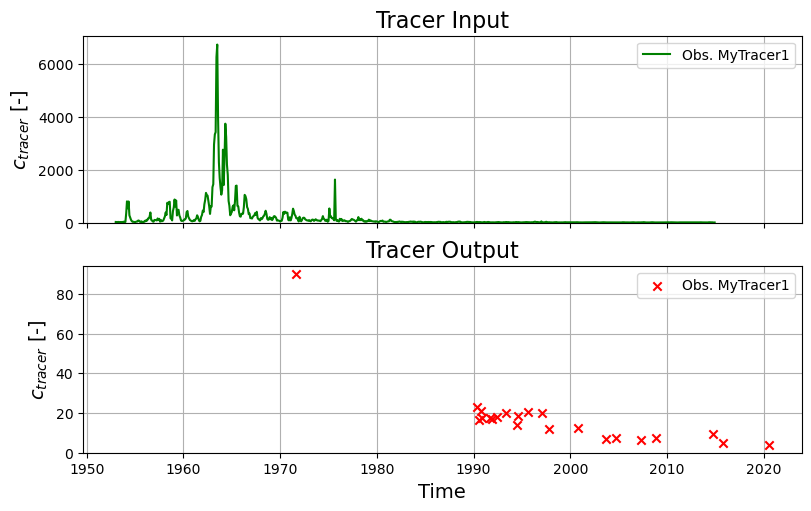

In [191]:
print('Here you can see your input data and the sample values')
sample_vis = sample.drop(sample[sample[3] == 0].index)
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1, figsize=(8, 5), constrained_layout=True, sharex=True)

ax1.plot(rain['Date'], rain[3], label='Obs. %s' % name_tracer_1, color='green')
ax1.plot(sample_vis['Date'], sample_vis[1], visible=False)
ax1.legend()
ax2.scatter(sample_vis['Date'], sample_vis[1], label='Obs. %s' % name_tracer_1, marker='x', zorder=5, c="red")
ax2.legend()
ax1.set_title("Tracer Input", fontsize=16)
ax1.set_ylabel('$c_{tracer}$ [-]', fontsize=14)
ax1.set_ylim(0)

ax2.set_title("Tracer Output", fontsize=16)
ax2.set_ylabel('$c_{tracer}$ [-]', fontsize=14)
ax2.set_xlabel('Time', fontsize=14)
ax2.set_ylim(0)
ax1.grid(zorder=0)
ax2.grid(zorder=0)

### Step 3: Model Setup

#### 3.1 Parameterization

&rarr; Instatiating the parameterization object (`ISOSIMpy.Par()`)

In [192]:
# instantiate / initialize the parameterization object
Par()

# set initial run / model number
Par.n = 0

# set monthly step (i.e., decay constant is divided by 12 and mean TT is multiplied by 12)
Par.step = 0

#### 3.2 Specifying the Vadose Zone Representation

&rarr; Specifying the vadose zone representation (as given by the `Par.SOILM` attribute of the parameterization object)

In [193]:
print('This is not integrated as a dynamic parameter. Set value once and do not change.')
print('Calculation in the vadose zone:')

# set the vadose zone parameter (specifying the vadose tone representation / handling)
def setVadoseZone(vadose_zone):
    if vadose_zone == 'No calculation':
        Par.SOILM = 0
    elif vadose_zone == 'Calculation based on monthly factor':
        print('To use this functionality, you must implement it manually')
        # Par.SOILM = 1
    elif vadose_zone == 'Calculation based on hydrologic model':
        # Par.SOILM = 2
        print('To use this functionality, you must implement it manually')
interact(setVadoseZone, vadose_zone = widgets.RadioButtons(options=['No calculation',
                                       'Calculation based on monthly factor [NOT IMPLEMENTED]',
                                       'Calculation based on hydrologic model [NOT IMPLEMENTED]'],
                              layout={'width': 'max-content'},
                              description='Calculation in the vadose zone:',
        style={'description_width': 'initial'}))

This is not integrated as a dynamic parameter. Set value once and do not change.
Calculation in the vadose zone:


interactive(children=(RadioButtons(description='Calculation in the vadose zone:', layout=Layout(width='max-con…

<function __main__.setVadoseZone(vadose_zone)>

&rarr; Handling recharge (here, the recharge water tracer concentration is set to the tracer concentration of precipitation water)

In [194]:
if Par.SOILM == 0:
    print('The tracer concentration in recharge water is assumed to be equal to the concentration in precipitation water.')
    Cin = rain['weighted_c']
elif Par.SOILM == 1:
    pass
elif Par.SOILM == 2:
    pass

The tracer concentration in recharge water is assumed to be equal to the concentration in precipitation water.


&rarr; Giving the user feedback on the state of the model setup

In [195]:
print(
    '\nAll basic settings are now made.\
     \nThe settings that are now still necessary must be selected once at the beginning for the first model run.\
     \nYou then have the possibility to change the parameter combination and compare different variants.\n'
)


All basic settings are now made.     
The settings that are now still necessary must be selected once at the beginning for the first model run.     
You then have the possibility to change the parameter combination and compare different variants.



#### 3.3 Setting Model Parameters

&rarr; Specifying model parameter values to run the model with

In [196]:
print('Model type and parameter values:')
def setParameters(model, mean_tt, half_time, pd, eta):
    if model == 'Piston Flow Model (MTT, HL)':
        Par.MODNUM = 1
    elif model == 'Exponential Model (MTT, HL)':
        Par.MODNUM = 2
    elif model == 'Dispersion Model (MTT, HL, PD)':
        Par.MODNUM = 3
    elif model == 'Linear Model (MTT, HL)':
        Par.MODNUM = 4
    elif model == 'Exponential - Piston Flow Model (MTT, HL, PD, E)':
        Par.MODNUM = 5
    Par.TT = mean_tt
    Par.Thalf_1 = half_time
    Par.PD = pd
    Par.eta = eta
interact(setParameters,
    model = widgets.RadioButtons(options=['Piston Flow Model (MTT, HL)',
                                       'Exponential Model (MTT, HL)',
                                       'Dispersion Model (MTT, HL, PD)',
                                       'Linear Model (MTT, HL)',
                                       'Exponential - Piston Flow Model (MTT, HL, PD, E)'],
                              layout={'width': 'max-content'},
                              description='Modeltype:',
        style={'description_width': 'initial'}),
    mean_tt = widgets.BoundedIntText(value=10, min=1, max=100, step=1,
                                     description='Mean Travel Time (MTT) [a]:',
                                    style={'description_width': 'initial'}),
    half_time = widgets.BoundedFloatText(value=10, min=1, max=100, step=0.001,
                                         description='Half Life (HL) [a]:',
                                        style={'description_width': 'initial'}),
    pd = widgets.BoundedFloatText(value=0.1, min=0.01, max=1000, step=0.01,
                             description='Dispersion Parameter (PD) [-]:',
                                 style={'description_width': 'initial'}),
    eta = widgets.BoundedFloatText(value=0.5, min=0.01, max=1, step=0.01,
                             description='Exp. Flow Fraction (E) [-]:',
                                  style={'description_width': 'initial'}))

Model type and parameter values:


interactive(children=(RadioButtons(description='Modeltype:', layout=Layout(width='max-content'), options=('Pis…

<function __main__.setParameters(model, mean_tt, half_time, pd, eta)>

### Step 4: Running the Model
- **Note**: if you re-run the model multiple times, you can save some time:
    1. specify the parameters above
    2. select this cell here
    3. in the toolbar above, select `Run` &rarr; `Run Selected Cell and All Below`

#### 4.1 Running the model

&rarr; Running the model with the parameterization object, input concentration data and precipitation data

In [252]:
# increase model (run) number by 1
Par.n += 1

# obtain the result
result = Tracer(Par, Cin, rain)

#### 4.2 Calculating Fit Metrics

&rarr; Calculate $ MSE $ and $ R^2 $ for the simulation

In [253]:
""" use only directly available values """

# get the number of available observations
orig_length = len(sample_vis[1])

# make pandas Series (a time series) from model results
results_series = pd.Series(data=result.result, index=rain['Date'])

# get model results at dates which are available from the observations
results_filtered = results_series.filter(items=sample_vis['Date'].dt.round("d"))

# set the index of the observations Series to be the Date column
sample_ = sample_vis.set_index(['Date'])

# get observations at dates which are available from the (already reduced / truncated) model results
sample_ = sample_.loc[results_filtered.index]

# compute the correlation matrix for results and observations and select the cross-correlation
corr = np.corrcoef(x=sample_.iloc[:, 1], y=results_filtered[:])[0, 1]
# calculate the R^2
rsq = corr ** 2.

# calculate the MSE
mse = np.sum((sample_.iloc[:, 1] - results_filtered.values) ** 2.) / len(results_filtered[:])

# print the results
print("The R^2 is {:1.3f} and the MSE is {:1.3f}, based on {} out of {} possible values".format(rsq, mse, len(results_filtered[:]), orig_length))

""" use interpolation (interpolating results to observation dates) """

# make pandas Series (a time series) from model results
results_series = pd.Series(data=result.result, index=rain['Date'])
# force an index with daily frequency and interpolate
# NOTE: this is necessary as ISOSIMpy only returns results at the first of each month
#     but observations are available at other times / days so we need to have those observation
#     dates in the index as well
results_series = results_series.reindex(pd.date_range(start=results_series.index[0], end=results_series.index[-1], freq="D")).interpolate()
# truncate the resulting series to start at the first observation date and to end at the
#     last obervation date (at latest)
results_series = results_series.truncate(before=sample_vis['Date'].iloc[0], after=sample_vis['Date'].iloc[-1])
# drop remaining NaN values
results_series = results_series.reindex(sample_vis['Date']).dropna()

# set the index of the observation data to be the date column and truncate to the date-range
#     of the results
sample_ = sample_vis.set_index(['Date'])
sample_ = sample_.truncate(before=results_series.index[0], after=results_series.index[-1])

# compute the correlation matrix for results and observations and select the cross-correlation
corr = np.corrcoef(x=sample_.iloc[:, 1].values, y=results_series.iloc[:].values)[0, 1]
# calculate the R^2
rsq = corr ** 2.

# calculate the MSE
mse = np.sum((sample_.iloc[:, 1].values - results_series.iloc[:].values) ** 2.) / len(results_series[:])

# print the results
print("The R^2 is {:1.3f} and the MSE is {:1.3f}, based on all values (linear interpolation)".format(rsq, mse))

The R^2 is 1.000 and the MSE is 1.362, based on 2 out of 22 possible values
The R^2 is 0.937 and the MSE is 2131.690, based on all values (linear interpolation)


#### 4.3 Exporting Model Specifications and Model Reults
- model settings / parameter values are written to a `log.txt`-file
- model results are written to a `results_{}.csv`-file, where the model run number is used instead of the curly brackets

&rarr; Write to log-file

In [254]:
with open(r'model_output/log.txt', 'a') as f:
    f.write(str(datetime.now()))
    f.write(';' + str(Par.n))
    f.write(';' + str(Par.MODNUM))
    f.write(';' + str(Par.TT))
    f.write(';' + str(Par.Thalf_1))
    f.write(';' + str(Par.PD))
    f.write(';' + str(Par.eta))
    f.write('\n')

&rarr; Write results file

In [255]:
results_series.to_csv(r'model_output/results_{}.csv'.format(Par.n), sep=';')

#### 4.4 Plotting Model Results

&rarr; Plotting model results (the modelled tracer concentration in the observation well)

Here you can see your input data and the simulation results


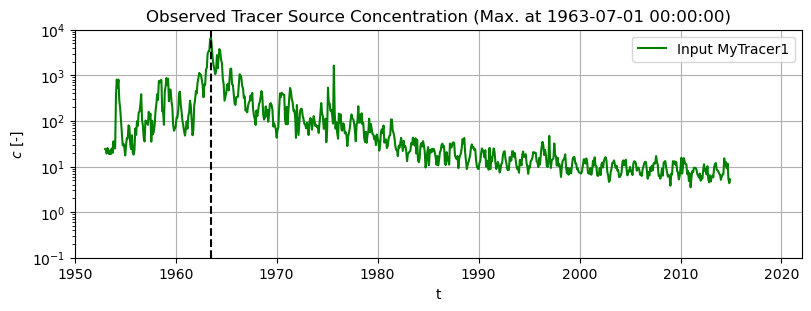

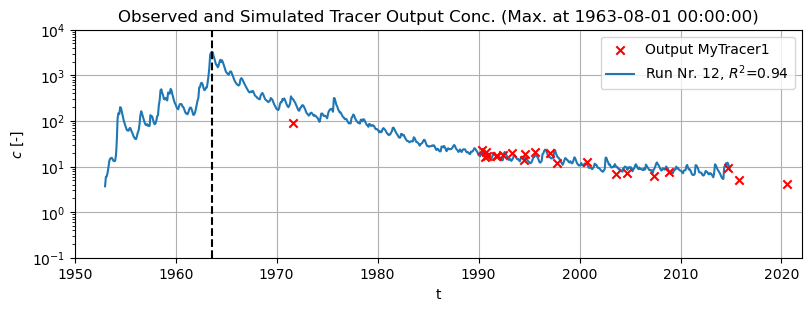

In [256]:
print('Here you can see your input data and the simulation results')
sample_vis = sample.drop(sample[sample[3] == 0].index)
fig3, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(8, 3), constrained_layout=True)
ax3.plot(rain['Date'], rain[3], label='Input %s' % name_tracer_1, color='green')
ax3.axvline(rain.iloc[np.argmax(rain[3]), 4], ls="--", c="black")
ax3.legend()
ax3.grid(zorder=0)
ax3.tick_params(axis='x', which='minor', bottom=False)
ax3.set(title='Observed Tracer Source Concentration (Max. at {})'.format(rain.iloc[np.argmax(rain[3]), 4]),
        ylabel='$c$ [-]',
        xlabel='t',
        ylim=(1e-1, 1e4),
        xlim=(pd.to_datetime("1950-01-01"), pd.to_datetime("2022-01-01")),
        yscale="log")

fig4, ax4 = plt.subplots(nrows=1, ncols=1, figsize=(8, 3), constrained_layout=True)
ax4.scatter(sample_vis['Date'], sample_vis[1], label='Output %s' % name_tracer_1, marker='x', zorder=5, c="red")
ax4.plot(rain['Date'], result.result, label='Run Nr. {}, $R^2$={:1.2f}'.format(Par.n, rsq))
ax4.axvline(rain.iloc[np.argmax(result.result), 4], ls="--", c="black")
ax4.legend()
ax4.grid(zorder=0)
ax4.set(title='Observed and Simulated Tracer Output Conc. (Max. at {})'.format(rain.iloc[np.argmax(result.result), 4]),
        ylabel='$c$ [-]',
        xlabel='t',
        ylim=(1e-1, 1e4),
        xlim=(pd.to_datetime("1950-01-01"), pd.to_datetime("2022-01-01")),
        yscale="log")

# save figure
# model mtt hl pd eta
plt.savefig("model_run_{}_{}_{}_{}_{}.png".format(Par.MODNUM, Par.TT, Par.Thalf_1, Par.PD, Par.eta), dpi=400)

&rarr; Plotting the Source Concentration and all Previous Modelling Results from the Current Session